In [17]:
from loader1 import *
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [18]:
_ = load_all()

Some files already exist in your CACHE_DIR. If you still want to run this function,              run with override=True


In [19]:
gps = read_data('gps')
orders = read_data('order')

In [20]:
gps.shape, orders.shape

((32155517, 5), (209423, 7))

In [25]:
# Run util functions
gps = convert_unix_ts(gps, timecols=['timestamp'])
orders = convert_unix_ts(orders, timecols=['ride_start_timestamp', 'ride_stop_timestamp'])
orders = ride_duration(orders)

In [22]:
# Add driverid in orders column
drivers = gps[['driver_id', 'order_id']].drop_duplicates()
orders = orders.merge(drivers, on='order_id', how='left')

In [52]:
orders.head()

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
0,eb9dd4095d9850e6287cefd813775a6c,2016-11-01 01:46:37,2016-11-01 02:15:07,104.094640,30.703971,104.089270,30.650850,28.500000,0373c98625e6d8e1fc56a4d61318138c
1,387a742fa5a3fbe4a1f215ac58ea33a8,2016-11-01 07:33:05,2016-11-01 08:07:55,104.076509,30.767430,104.063700,30.589510,34.833333,0373c98625e6d8e1fc56a4d61318138c
2,9cf55f8e6e02a1e0f792df06e5d85011,2016-11-01 12:55:52,2016-11-01 13:16:57,104.019699,30.689007,104.105324,30.663950,21.083333,0373c98625e6d8e1fc56a4d61318138c
3,5feeae0307e15203484b9ffceef89855,2016-11-01 08:44:00,2016-11-01 09:04:25,104.036090,30.622690,104.043860,30.682320,20.416667,0373c98625e6d8e1fc56a4d61318138c
4,ad4b52cb15b90c44c8f20a8b1e57a622,2016-10-31 23:53:25,2016-11-01 00:02:57,104.115997,30.652313,104.104421,30.695113,9.533333,0373c98625e6d8e1fc56a4d61318138c


In [46]:
driver_ride_durations = orders.groupby('driver_id')[['ride_duration']].sum().reset_index()

### Single day total active time

In [57]:
driver_day_min = pd.DataFrame(orders.groupby('driver_id')['ride_start_timestamp'].min()).reset_index()
driver_day_max = pd.DataFrame(orders.groupby('driver_id')['ride_stop_timestamp'].max()).reset_index()
driver_active_time = driver_day_min.merge(driver_day_max, on='driver_id', how='left')
driver_active_time['active_time'] = (driver_active_time['ride_stop_timestamp'] - driver_active_time['ride_start_timestamp']).dt.seconds / 60
driver_active_time.head()

### Comparing total driver active time vs ride time

In [61]:
# total driver active time
driver_stats = driver_active_time[['driver_id', 'active_time']].merge(driver_ride_durations, on='driver_id', how='left') 

# Filtering possible bad rows
driver_stats = driver_stats[driver_stats.active_time > driver_stats.ride_duration]

driver_stats.describe()

## Scatter plot of active time vs. ride duration

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

[]

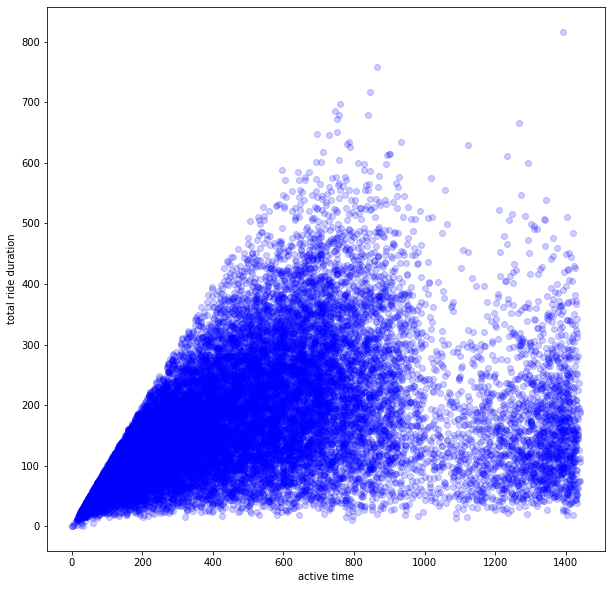

In [75]:
plt.figure(figsize=(10,10))
plt.scatter(driver_stats['active_time'], driver_stats['ride_duration'], c='b', alpha=0.2)
plt.ylabel('total ride duration')
plt.xlabel('active time')
plt.plot()